# Goal 1: Create a CNN Model1 to classify CIFAR according to the following specifications

1. 2 layers of Convolution with filters having: Size of 1 X (5 X 5) X 6 and Size of 6 X (5 X 5) X 10
2. For each layer, use ReLU
3. After the second layer (and after ReLU), use Max Pooling
4. Feed into a fully connected layer (FCC)

The architecture should take the following form:

6 Conv1 Filter(s) of size 1 X (5 X 5) ---> ReLU ---> 10 Conv1 Filter(s) of size 6 X (5 X 5) ---> ReLU ---> Max Pooling ---> FCC

# Goal 2: Use the CNN Model1 for Transfer Learning 

1. Save the parameters from Model1 (up to the fully connected layer) 
2. Train the fully connected layer for classification of categories 0 and 1

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [48]:
transform = transforms.Compose([transforms.ToTensor()])#,
#                                 transforms.Normalize((0.1307,), (0.3081,))  ])

training_data = torchvision.datasets.CIFAR10(root = './data_CIFAR10',
                                          download = True,
                                          train = True, 
                                          transform = transform)

test_data = torchvision.datasets.CIFAR10(root = './data_CIFAR10',
                                          download = True,
                                          train = False, 
                                          transform = transform)

train_loader = torch.utils.data.DataLoader(training_data, 
                                          batch_size = 4,
                                          shuffle = True,
                                          num_workers = 2)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = 4,
                                          shuffle = False,
                                          num_workers = 2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def show_image(img):
    img = img
    img = img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))

In [11]:
dataiter = iter(train_loader)
img, labels = dataiter.next()

tensor([5, 5, 5, 6])


torch.Size([4, 3, 32, 32])

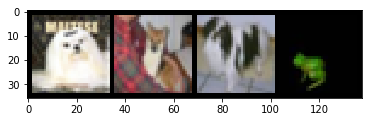

In [25]:
show_image(torchvision.utils.make_grid(img, nrow = 8))
print(labels)
img.shape

In [26]:
class Net(nn.Module):
    def __init__(self, filter1_width, filter1_height, filter1_depth, filter1_OC,
                filter2_width, filter2_height, filter2_OC,
                FCC_out):
        super(Net,self).__init__()
        self.C1 = nn.Conv2d(in_channels = filter1_depth, 
                           out_channels = filter1_OC,
                           kernel_size = (filter1_height,filter1_width))
        self.C2 = nn.Conv2d(in_channels = filter1_OC, 
                           out_channels = filter2_OC,
                           kernel_size = (filter2_height,filter2_width))
        self.MP = nn.MaxPool2d(kernel_size = 2)
        self.FC_in_dim = (32 - filter1_height - filter2_height + 2)/2
        self.FC = nn.Linear(int(filter2_OC * self.FC_in_dim**2)  ,FCC_out)
        
    def forward(self,x):
        x = self.C1(x)
        x = F.relu(x)
        x = self.C2(x)
        x = F.relu(x)
        x = self.MP(x)
        x = x.view(4,-1)
        
        x = self.FC(x)
        return x

In [28]:
net = Net(filter1_width = 5,
          filter1_height = 5,
          filter1_depth = 3, 
          filter1_OC = 6,
          filter2_width = 5, 
          filter2_height = 5, 
          filter2_OC = 10,
          FCC_out = 10)

In [29]:
optimizer = optim.SGD(net.parameters(), lr = 0.003)

In [30]:
loss_function = nn.CrossEntropyLoss()

In [34]:
epoch = 2
for j in range(epoch):
    running_loss = 0
    for i,data in enumerate(train_loader):
        x, y = data
        y_pred = net(x)
        loss = loss_function(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + float(loss)
        
        if i%2000 == 1999:
            print('i =', i, 'Loss = ',running_loss/2000 )
            running_loss = 0

i = 1999 Loss =  1.3813225802332163
i = 3999 Loss =  1.3949446150362492
i = 5999 Loss =  1.3845300104022027
i = 7999 Loss =  1.377676162198186
i = 9999 Loss =  1.346815423861146
i = 11999 Loss =  1.3778857464641332
i = 1999 Loss =  1.3193471137583255
i = 3999 Loss =  1.2944254727959632
i = 5999 Loss =  1.305238520398736
i = 7999 Loss =  1.2999474112689495
i = 9999 Loss =  1.2781052700728177
i = 11999 Loss =  1.2801065874248743


In [35]:
label_count = torch.zeros(10)
correct_count = torch.zeros(10)

for data in test_loader:
    x, labels = data
    pred_y = net(x)
    _, pred_y = pred_y.max(1)
    
    c = torch.eq(pred_y, labels)
    for j, label in enumerate(labels):
        label_count[label] = label_count[label] + 1
        correct_count[label] = correct_count[label] + c[j]
    

In [36]:
print('Accuracy by Class:')
for i in range(10):
    print(i,':', ((correct_count[i]/label_count[i]).numpy() * 100).round(1), '%')
print('Overall Accuracy:', ((correct_count.sum()/label_count.sum()*100).numpy()).round(1), '%')

Accuracy by Class:
0 : 43.4 %
1 : 48.3 %
2 : 41.6 %
3 : 35.7 %
4 : 27.6 %
5 : 49.0 %
6 : 66.7 %
7 : 64.4 %
8 : 87.9 %
9 : 58.4 %
Overall Accuracy: 52.3 %


## Save the parameters for comparison later

In [37]:
torch.save(net.state_dict(), 'CIFAR10_CNN_before_transfer.pwf')

## Print out some of the parameters for the layers before the FC layer

Now extract two classes (say 0 and 1) from the training and testing data

In [168]:
# Get the indices of the zeros and ones
train_temp_indices = (np.array(training_data.train_labels) <= 1) * np.arange(len(training_data))
train_temp_indices = train_temp_indices[train_temp_indices != 0]

training_data_01 = torch.utils.data.Subset(training_data, train_temp_indices)

test_temp_indices = (np.array(test_data.test_labels) <= 1) * np.arange(len(test_data))
test_temp_indices = test_temp_indices[test_temp_indices != 0]

test_data_01 = torch.utils.data.Subset(test_data, test_temp_indices)



train_loader_01 = torch.utils.data.DataLoader(training_data_01, 
                                          batch_size = 4,
                                          shuffle = True,
                                          num_workers = 2)

test_loader_01 = torch.utils.data.DataLoader(test_data_01, 
                                          batch_size = 4,
                                          shuffle = False,
                                          num_workers = 2)

## Ensure that the parameters before the FC layer have not changed

Print out the weight for one of the kernels to compare with later

In [173]:
net.state_dict()['C1.weight'][0][0].numpy().squeeze().round(3)

array([[ 0.004, -0.164,  0.002, -0.105, -0.129],
       [-0.246, -0.17 , -0.237, -0.193, -0.074],
       [-0.217, -0.201, -0.217, -0.013, -0.029],
       [-0.197, -0.146, -0.141,  0.067, -0.15 ],
       [ 0.019,  0.105, -0.052,  0.073,  0.088]], dtype=float32)

In [148]:
for i,param in enumerate(net.parameters() ):
    if i < 4:
        param.requires_grad = False

In [158]:
epoch = 5
for j in range(epoch):
    running_loss = 0
    for i,data in enumerate(train_loader_01):
        x, y = data
        y_pred = net(x)
        loss = loss_function(y_pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + float(loss)
        
        if i%2000 == 1999:
            print('i =', i, 'Loss = ',running_loss/2000 )
            running_loss = 0
        

i = 1999 Loss =  0.2220357438325882
i = 1999 Loss =  0.21316622188687326
i = 1999 Loss =  0.21224788546562195
i = 1999 Loss =  0.2083808613717556
i = 1999 Loss =  0.20638595950603486


## The parameters before the FC layer have not changed.

In [172]:
net.state_dict()['C1.weight'][0][0].numpy()squeeze().round(3)

array([[ 0.004, -0.164,  0.002, -0.105, -0.129],
       [-0.246, -0.17 , -0.237, -0.193, -0.074],
       [-0.217, -0.201, -0.217, -0.013, -0.029],
       [-0.197, -0.146, -0.141,  0.067, -0.15 ],
       [ 0.019,  0.105, -0.052,  0.073,  0.088]], dtype=float32)

## Evaluate the test set

In [169]:
label_count_01 = torch.zeros(2)
correct_count_01 = torch.zeros(2)

for data in test_loader_01:
    x, labels = data
    pred_y = net(x)
    _, pred_y = pred_y.max(1)

    c = torch.eq(pred_y, labels)
    for j, label in enumerate(labels):
        label_count_01[label] = label_count_01[label] + 1
        correct_count_01[label] = correct_count_01[label] + c[j]
    

## As we can see below, simply by changing the FC layer we will be able to increase the accuracy for the first and second classes. 

In [170]:
print('Accuracy by Class:')
for i in range(2):
    print(i,':', ((correct_count_01[i]/label_count_01[i]).numpy() * 100).round(1), '%')
print('Overall Accuracy:', ((correct_count_01.sum()/label_count_01.sum()*100).numpy()).round(1), '%')

Accuracy by Class:
0 : 89.4 %
1 : 93.4 %
Overall Accuracy: 91.4 %
